In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import gzip,pickle
import mytorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from time import time

In [3]:
tr,va,te=pickle.load(gzip.open('data/mnist.pkl.gz'),encoding='latin1')

In [4]:
def normalize(x,mean,std): return (x-mean)/std
tr_mean,tr_std=tr[0].mean(),tr[0].std()
tr=(normalize(tr[0],tr_mean,tr_std),tr[1])
va=(normalize(va[0],tr_mean,tr_std),va[1])
te=(normalize(te[0],tr_mean,tr_std),te[1])

In [5]:
n_in=te[0].shape[1]
n_out=te[1].max()+1
n_in,n_out

(784, 10)

In [5]:
def vectorize_y(y):
    def vectorize(i):
        v=np.zeros(10)
        v[i]=1.
        return v
    return np.array([vectorize(i) for i in y])

In [6]:
def nll_loss(p,targ): return -p[mytorch.arange(len(p)),targ].sum()/np.float32(len(p))
# def nll_loss(p,targ): return -p[mytorch.arange(len(p)),targ].log().sum()/len(p)
def cross_entropy(p,targ): return -(targ*p.log()+(1.-targ)*(1.-p).log()).sum()/len(p)
def accuracy(p,targ): return (p.argmax(axis=1)==targ).mean()

In [320]:
# %%prun
# X,y=mytorch.tensor(tr[0]),mytorch.tensor(vectorize_y(tr[1]))
X,y=mytorch.tensor(tr[0]),mytorch.tensor(tr[1])
n_hid=30
N=len(X)
# N=10
n_ep=3
lr=.5
batch_size=10

np.random.seed(1)
mytorch.manual_seed(1)
m=mytorch.Seq(
    mytorch.Linear(n_in,n_hid)
    ,mytorch.Sigmoid()
    ,mytorch.Linear(n_hid,n_out)
#     ,mytorch.Sigmoid()
    ,mytorch.LogSoftmax()
#     ,mytorch.Softmax()
)
# print(m.modules[0].w,m.modules[2].w)
losses,accs=[],[]
t0=time()
for ep in range(n_ep):
    idxs=np.random.permutation(N)
    for i in range(0,N,batch_size):
        ibatch=idxs[i:i+batch_size]
#         print(ibatch)
        xb,yb=X[ibatch],y[ibatch]
#         loss=cross_entropy(m(xb),yb)
        loss=nll_loss(m(xb),yb)
#         print(loss)
        loss.backward()
        with mytorch.no_grad():
            for p in m.params():
#                 print(p.grad.reshape(-1)[:3])
                p-=lr*p.grad
                p.grad.zero_()
                
    with mytorch.no_grad():
        probs=m(mytorch.tensor(te[0]))
#         losses.append(cross_entropy(probs,vectorize_y(te[1])))
        vy=mytorch.tensor(te[1])
        losses.append(nll_loss(probs,vy))
        accs.append(accuracy(probs,vy))
        print(losses[-1],accs[-1])
print(time()-t0,'s')
losses=mytorch.tensor(losses)
accs=mytorch.tensor(accs)
# plt.plot(losses)
# plt.show()
# plt.plot(accs)

tensor(0.33746768) tensor(0.9026)
tensor(0.27810104) tensor(0.9182)
tensor(0.2660433) tensor(0.9229)
35.44679498672485 s


In [81]:
loss.v.dtype

dtype('float64')

In [146]:
def sigmoid(x): return 1./(1.+np.exp(-x))
def sigmoid_prime(x): return x*(1.-x)
def softmax(x):
    e=np.exp(x)
    return e/e.sum(axis=1,keepdims=True)

0.632670942572302 0.9003
0.5478507429896013 0.9132
0.478934529252819 0.9288
0.44079300268784827 0.9364
0.5421477966668914 0.9199
0.41838746069623023 0.9388
0.4530470989045172 0.9378
0.4752314444853332 0.9329
0.4197020298671103 0.9422
0.40289795544745466 0.9416
0.4362184010630118 0.9402
0.39924739439404383 0.9462
0.4167554304909834 0.9402
0.3766483564398313 0.9468
0.3701037060569102 0.9477
0.3932910751707165 0.9461
0.37327370489263767 0.9496
0.3868993280898096 0.9453
0.4091943511821956 0.9436
0.34642862320397433 0.9515
0.38650600151485465 0.9435
0.3750960414102017 0.9474
0.35714398218672333 0.9517
0.3765891977557906 0.9503
0.3609661577212279 0.9512
0.36368937064158297 0.9507
0.38040249256142344 0.9464
0.37698987613327417 0.9498
0.3874604429172612 0.9471
0.3589867607447862 0.95
58.40710520744324 s


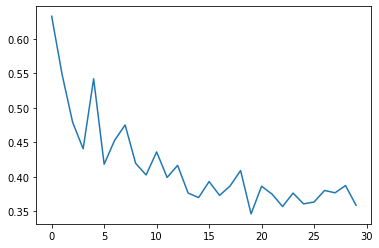

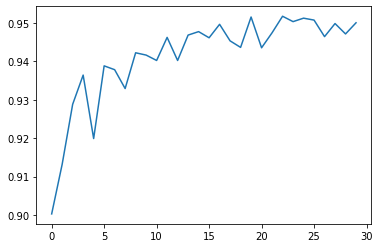

In [116]:
lr=3.

X=tr[0]
# y=tr[1]
y=vectorize_y(tr[1])
N=len(X)
batch_size=10
n_ep=30

losses=[]
accs=[]
np.random.seed(17)
w1,b1=np.random.randn(n_in,n_hid),np.random.randn(n_hid)
w2,b2=np.random.randn(n_hid,n_out),np.random.randn(n_out)
t0=time()
for ep in range(n_ep):
    idxs=np.random.permutation(N)
    for i in range(0,N,batch_size):
        ibatch=idxs[i:i+batch_size]
        xb,yb=X[ibatch],y[ibatch]
        a1=sigmoid(xb@w1+b1)
#         a2=softmax(a1@w2+b2)
        a2=sigmoid(a1@w2+b2)

#         # log-likelihood
#         d2=np.zeros_like(a2)
#         d2[np.arange(len(d2)),yb]=a2[np.arange(len(a2)),yb]-1.
        # cross-entropy
        d2=a2-yb
        d1=d2@w2.T*sigmoid_prime(a1)
        
        gw2=a1.T@d2
        gb2=d2.sum(axis=0)
        gw1=xb.T@d1
        gb1=d1.sum(axis=0)
        
        w2-=lr/batch_size*gw2
        b2-=lr/batch_size*gb2
        w1-=lr/batch_size*gw1
        b1-=lr/batch_size*gb1
    
#     probs=softmax(sigmoid(te[0]@w1+b1)@w2+b2)
#     loss=-np.log(probs[np.arange(len(probs)),te[1]]).sum()/len(probs)
    probs=sigmoid(sigmoid(te[0]@w1+b1)@w2+b2)
    vy=vectorize_y(te[1])
    loss=-(vy*np.log(probs)+(1.-vy)*np.log(1.-probs)).sum()/len(probs)
    acc=np.mean(np.argmax(probs,axis=1)==te[1])
    print(loss,acc)
    losses.append(loss)
    accs.append(acc)
print(time()-t0,'s')
plt.plot(losses)
plt.show()
plt.plot(accs)

In [267]:
X,y=torch.tensor(tr[0]),torch.tensor(tr[1])
N=len(X)
# N=5
# ds=TensorDataset(X,y)

class Linear(nn.Module):
    def __init__(self,n_in,n_out):
        super().__init__()
        self.w=nn.Parameter(torch.from_numpy(np.asarray(np.random.randn(n_in,n_out),dtype=np.float32)))
        self.b=nn.Parameter(torch.zeros(n_out))
    def forward(self,x): return x@self.w+self.b
class Sigmoid(nn.Module):
    def forward(self,x): return 1./(1.+(-x).exp())
class LogSoftmax(nn.Module):
    def forward(self,x): return x-x.exp().sum(dim=1,keepdim=True).log()
# class Linear:
#     def __init__(self,n_in,n_out):
#         self.w=torch.tensor(np.random.randn(n_in,n_out),dtype=torch.float,requires_grad=True)
#         self.b=torch.zeros(n_out,requires_grad=True)
#     def __call__(self,x): return x@self.w+self.b
# class Sigmoid:
#     def __call__(self,x): return 1./(1.+(-x).exp())
# class LogSoftmax:
#     def __call__(self,x): return x-x.exp().sum(dim=1,keepdim=True).log()

np.random.seed(1)
torch.manual_seed(1)
n_hid=30
l1=Linear(n_in,n_hid)
sig1=Sigmoid()
l2=Linear(n_hid,n_out)
smax2=LogSoftmax()
# print(l1.w,'\n',l2.w)
m=nn.Sequential(
#     nn.Linear(n_in,n_hid)
    l1
    ,nn.Sigmoid()
#     ,sig1
#     ,nn.Linear(n_hid,n_out)
    ,l2
#     ,smax2
    ,nn.LogSoftmax(dim=1)
)

batch_size=10
n_ep=3
lr=.45

losses=[]
accs=[]
opt=optim.SGD(m.parameters(),lr=lr)
t0=time()
def loss_fn(p,targ): return -p[torch.arange(len(p)),targ].sum()/len(p)
def predict(x): return m(x)
# def predict(x): return smax2(l2(sig1(l1(x))))
np.random.seed(1)
for ep in range(n_ep):
    idxs=np.random.permutation(N)
    for i in range(0,N,batch_size):
        ibatch=idxs[i:i+batch_size]
#         print(ibatch)
        xb,yb=X[ibatch],y[ibatch]
#     dl=DataLoader(ds,batch_size=batch_size,shuffle=True)
#     for xb,yb in dl:
        probs=predict(xb)
#         loss=F.nll_loss(probs,yb)
        loss=loss_fn(probs,yb)
#         print(probs)
#         loss=loss_fn(probs,yb)
#         print(loss)
        loss.backward()
#         loss_fn(probs,yb).backward()
#         opt.step()
#         opt.zero_grad()
        with torch.no_grad():
            for p in m.parameters():
#             for p in [l1.w,l1.b,l2.w,l2.b]:
#                 print(p.grad.reshape(-1)[:3])
#                 print('before',p,'grad',p.grad)
                p-=lr*p.grad
#                 print('after',p)
                p.grad.zero_()
    
    with torch.no_grad():
        probs=predict(torch.tensor(te[0]))
        vy=torch.tensor(te[1])
#         loss=F.nll_loss(probs,vy)
        loss=loss_fn(probs,vy)
        losses.append(loss)
        acc=(probs.argmax(axis=1)==vy).float().mean()
        accs.append(acc)
        print(losses[-1],accs[-1])
print(time()-t0,'s')
# plt.plot(losses)
# plt.show()
# plt.plot(accs)

tensor(0.3577) tensor(0.8932)
tensor(0.3179) tensor(0.9081)
tensor(0.2748) tensor(0.9231)
23.523262977600098 s


In [167]:
# %%prun
# X,y=mytorch.tensor(tr[0]),mytorch.tensor(vectorize_y(tr[1]))
X,y=mytorch.tensor(tr[0]),mytorch.tensor(tr[1])
# print(X.dtype,y.dtype)
n_hid=30
N=len(X)
# N=10
n_ep=10
lr=.5
batch_size=10

np.random.seed(1)
mytorch.manual_seed(1)
m=mytorch.Seq(
    mytorch.Linear(n_in,n_hid)
    ,mytorch.Sigmoid()
    ,mytorch.Linear(n_hid,n_out)
#     ,mytorch.Sigmoid()
    ,mytorch.LogSoftmax()
#     ,mytorch.Softmax()
).to(mytorch.float32)
# print(m.modules[0].w.dtype,m.modules[0].b.dtype,m.modules[2].w.dtype,m.modules[2].b.dtype)
losses,accs=[],[]
t0=time()
for ep in range(n_ep):
    idxs=np.random.permutation(N)
    for i in range(0,N,batch_size):
        ibatch=idxs[i:i+batch_size]
#         print(ibatch)
        xb,yb=X[ibatch],y[ibatch]
#         loss=cross_entropy(m(xb),yb)
#         print(xb.dtype,m(xb).dtype)
        loss=nll_loss(m(xb),yb)
#         print('loss',loss.dtype)
#         print(loss)
        loss.backward()
        with mytorch.no_grad():
            for p in m.params():
#                 print(p.mean(),p.grad.mean())
#                 print('grad',p.grad.dtype)
                p-=lr*p.grad
                p.grad.zero_()
                
    with mytorch.no_grad():
        probs=m(mytorch.tensor(te[0]))
#         losses.append(cross_entropy(probs,vectorize_y(te[1])))
        vy=mytorch.tensor(te[1])
        losses.append(nll_loss(probs,vy))
        accs.append(accuracy(probs,vy))
        print(losses[-1],accs[-1])
print(time()-t0,'s')
losses=mytorch.tensor(losses)
accs=mytorch.tensor(accs)
# plt.plot(losses)
# plt.show()
# plt.plot(accs)

tensor(0.33745047, dtype=float32) tensor(0.9026)
tensor(0.27811417, dtype=float32) tensor(0.918)
tensor(0.26602763, dtype=float32) tensor(0.923)
tensor(0.24402644, dtype=float32) tensor(0.9281)
tensor(0.22023076, dtype=float32) tensor(0.9377)
tensor(0.20807666, dtype=float32) tensor(0.9417)
tensor(0.19453724, dtype=float32) tensor(0.9412)
tensor(0.20017874, dtype=float32) tensor(0.9433)
tensor(0.21266308, dtype=float32) tensor(0.9423)
tensor(0.19948587, dtype=float32) tensor(0.9462)
58.47255229949951 s


In [132]:
%%prun
s=mytorch.tensor(7.,do_grad=False)
u=mytorch.tensor(8.,do_grad=False)
for _ in range(300000):
    t=s*u
#     t.backward()
#     s.grad.zero_()
s.grad,u.grad

In [250]:
class Flatten(mytorch.Module):
    def forward(self,x): return x.reshape((len(x),-1))

# def getm():
#     return mytorch.Seq(
#         mytorch.Conv2d(1,8,5,padding=2,stride=2),mytorch.ReLU() # 1x28x28 -> 8x14x14
#         ,mytorch.Conv2d(8,16,3,padding=1,stride=2),mytorch.ReLU() # -> 16x7x7
#         ,mytorch.Conv2d(16,32,3,padding=1,stride=2),mytorch.ReLU() # -> 32x4x4
#         ,mytorch.Conv2d(32,32,3,padding=1,stride=2),mytorch.ReLU() # -> 32x2x2
#         ,Flatten()
#         ,mytorch.Linear(128,10)
#     ).to(mytorch.float32)

nh=50
def getm():
    return mytorch.Seq(
        mytorch.Linear(n_in,nh),mytorch.ReLU()
        ,mytorch.Linear(nh,10)
    ).to(mytorch.float32)

# def getm():
#     return mytorch.Seq(
#         mytorch.Conv2d(1,20,5),mytorch.ReLU() # 20x24x24
#         ,mytorch.MaxPool2d(2,stride=2) # 20x12x12
#         ,Flatten() # 20*12*12
#         ,mytorch.Linear(20*12*12,100),mytorch.ReLU() # 100
#         ,mytorch.Linear(100,10)
#     ).to(mytorch.float32)

In [252]:
batch_size=100
lr=.1
n_ep=5

def getdl(x,y,shuffle=False,xshape=None,first_n=None):
    x=x.reshape(xshape) if xshape else x
    if first_n: x,y=x[:first_n],y[:first_n]
    x,y=map(mytorch.tensor,[x,y])
    ds=mytorch.TensorDataset(x,y)
    return mytorch.DataLoader(ds,bs=batch_size,shuffle=shuffle)

# xshape=(-1,1,28,28)
xshape=None
trdl=getdl(*tr,shuffle=True)
vadl=getdl(*va)
# plt.imshow(next(iter(trdl))[0][3,0],cmap='gray')
m=getm()
opt=mytorch.SGD(m.params(),lr)

In [253]:
opt.zero_grad()
xb,yb=next(iter(trdl))
mytorch.cross_entropy(m(xb),yb).backward()
[(p.grad.mean(),p.grad.var()) for p in m.params()]

[(tensor(0.00051804, dtype=float32), tensor(0.00102046, dtype=float32)),
 (tensor(0.01242997, dtype=float32), tensor(0.00126717, dtype=float32)),
 (tensor(-7.4505807e-10, dtype=float32), tensor(0.00495924, dtype=float32)),
 (tensor(4.0978194e-09, dtype=float32), tensor(0.00434392, dtype=float32))]

In [254]:
t0=time()
for ep in range(n_ep):
    totloss=0.
    for xb,yb in trdl:
#         print(xb.sum(),yb.sum())
        loss=mytorch.cross_entropy(m(xb),yb)
        totloss+=loss.v*batch_size
#         print(loss)
        loss.backward()
        opt.step()
    print('train loss',totloss/len(trdl))

    with mytorch.no_grad():
        acc=0.
        loss=0.
        for xb,yb in vadl:
            yhat=mytorch.log_softmax(m(xb))
            acc+=(yhat.argmax(axis=1)==yb).sum()
            loss+=mytorch.nll_loss(yhat,yb)*batch_size
        print(acc/len(vadl),loss/len(vadl))
print(time()-t0,'s')

train loss 0.31385308139771223
tensor(0.9476) tensor(0.18492989)
train loss 0.16386096170544626
tensor(0.9602) tensor(0.13612051)
train loss 0.12639652191475034
tensor(0.9636) tensor(0.12403162)
train loss 0.10549794644489885
tensor(0.9677) tensor(0.10987234)
train loss 0.09007261226698757
tensor(0.9707) tensor(0.10001938)
6.202772617340088 s
